In [1]:
import os

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

import plotly.express as px

from Bio import SeqIO, Align

In [2]:
def get_seqs(filepath: str) -> pd.DataFrame:

    seqs = []

    with open(filepath, mode="r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            seqs.append(
                pd.Series({
                    "seq_id": record.id,
                    "seq": "".join(record.seq)
                }).to_frame().T
            )

    return pd.concat(seqs)

In [3]:
DATA_DIR = "../data/"

In [4]:
mediadive_df = pd.read_csv(
    os.path.join(
        DATA_DIR,
        "final_split",
        "y_split.csv"
    )
)

mediadive_df = mediadive_df\
    .drop("Unnamed: 0", axis=1)\
    .dropna(subset="taxon_id")
mediadive_df["taxon_id"] = mediadive_df["taxon_id"].astype(int).astype(str)

print(
    "[+] Number of taxon IDs in MediaDive:",
    mediadive_df["taxon_id"].nunique()
)

[+] Number of taxon IDs in MediaDive: 5913


Text(0.5, 1.0, 'Data leakage between train and test sets')

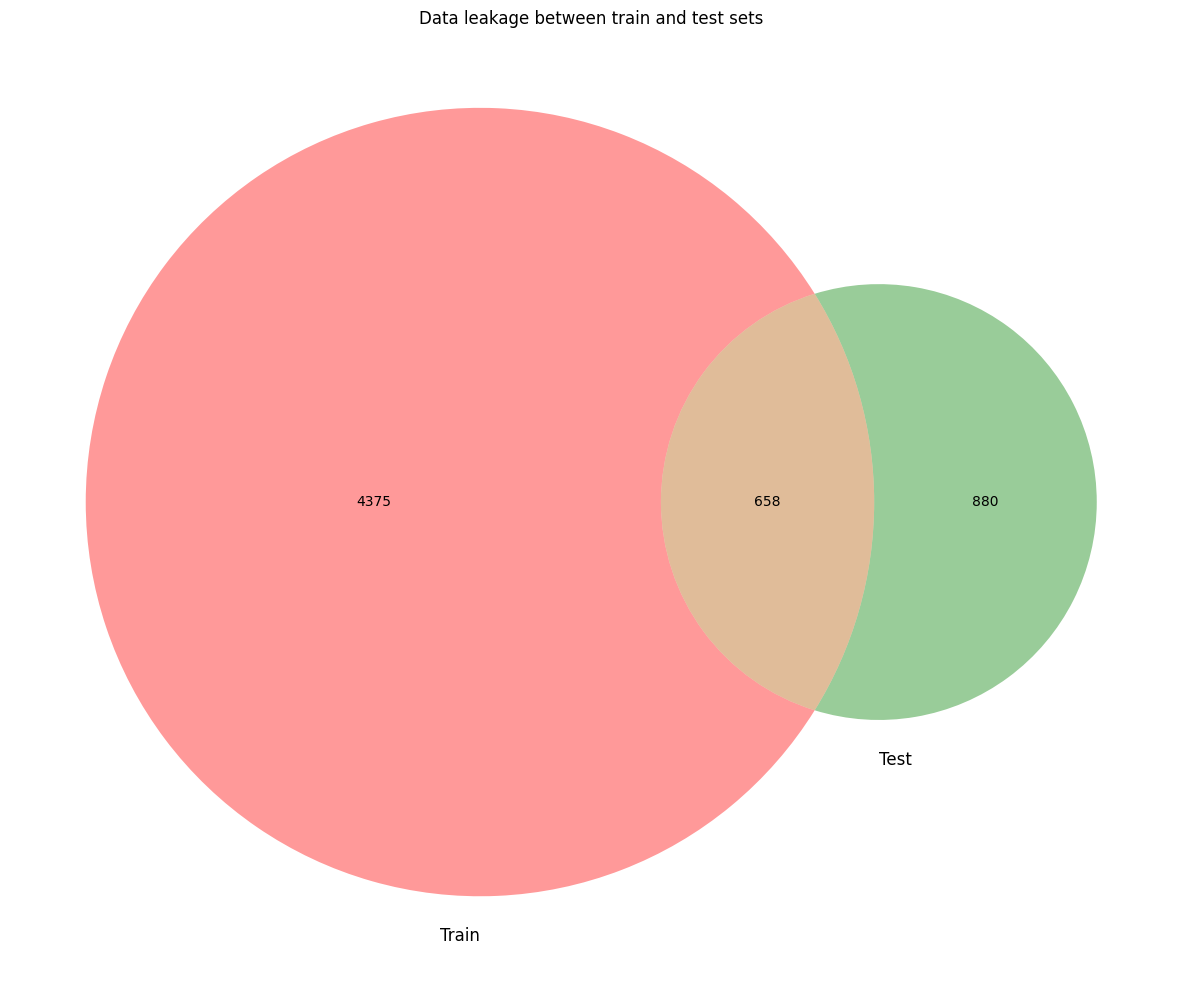

In [5]:
train_ids = mediadive_df[mediadive_df["Set"] == "Train"]["taxon_id"].to_numpy()
test_ids = mediadive_df[mediadive_df["Set"] == "Test"]["taxon_id"].to_numpy()

plt.figure(figsize=(15, 15))
venn2(
    [set(train_ids), set(test_ids)],
    set_labels=["Train", "Test"]
)
plt.title("Data leakage between train and test sets")

In [6]:
silva_taxmap = pd.read_table(
    os.path.join(
        DATA_DIR,
        "silva",
        "taxmap_embl-ebi_ena_ssu_ref_138.2.txt"
    )
)

# Discard eukaryotes
silva_taxmap = silva_taxmap[
    ~silva_taxmap["submitted_path"].str.startswith("Eukaryota;")
]

# Create sequence ID for matching with FASTA file
silva_taxmap["seq_id"] = \
    silva_taxmap["primaryAccession"] + "." + \
    silva_taxmap["start"].astype(str) + "." + \
    silva_taxmap["stop"].astype(str)

silva_seqs = get_seqs(
    os.path.join(
        DATA_DIR,
        "silva",
        "SILVA_138.2_SSURef_NR99_tax_silva.fasta"
    )
)

# Add SILVA sequences
silva_taxmap = pd.merge(
    left=silva_taxmap,
    right=silva_seqs,
    on="seq_id",
    how="inner"
)
silva_taxmap

,primaryAccession,start,stop,submitted_path,submitted_name,ncbi_taxonid,seq_id,seq
0,AB000278,1,1410,Bacteria;Proteobacteria;Gammaproteobacteria;Vi...,Photobacterium iliopiscarium,56192,AB000278.1.1410,CAGGCCUAACACAUGCAAGUCGAACGGUAANAGAUUGAUAGCUUGC...
1,AB000390,1,1428,Bacteria;Proteobacteria;Gammaproteobacteria;Vi...,Vibrio halioticoli,71388,AB000390.1.1428,CAUGCAAGUCGAGCGGAAACGAGUUGUCUGAACCUUCGGGGAACGA...
2,HL182401,2,1459,unclassified sequences;,unidentified,32644,HL182401.2.1459,AUACAUGCAAGUCGAGCGGACAGAUGGGAGCUUGCUCCCUGAUGUU...
3,AB000391,1,1471,Bacteria;Proteobacteria;Gammaproteobacteria;Vi...,Vibrio halioticoli,71388,AB000391.1.1471,ACACAUGCAAGUCGAGCGGAAACGAGUUAUCUGAACCUUCGGGGAA...
4,AB000392,1,1478,Bacteria;Proteobacteria;Gammaproteobacteria;Vi...,Vibrio halioticoli,71388,AB000392.1.1478,UGGCGGCAGGCCUAACACAUGCAAGUCGAGCGGAAACGAGUUNUCU...
...,...,...,...,...,...,...,...,...
447671,CRCX01000046,4493,6026,Bacteria;Firmicutes;Bacilli;Lactobacillales;St...,Streptococcus pneumoniae,1313,CRCX01000046.4493.6026,AGAGUUUGAUCCUGGCUCAGGACGAACGCUGGCGGCGUGCCUAAUA...
447672,CRUJ01000012,49416,51376,Bacteria;Firmicutes;Bacilli;Lactobacillales;St...,Streptococcus pneumoniae,1313,CRUJ01000012.49416.51376,AGAGUUUGAUCCUGGCUCAGGACGAACGCUGGCGGCGUGCCUAAUA...
447673,CRDG01000003,91516,93034,Bacteria;Firmicutes;Bacilli;Lactobacillales;St...,Streptococcus pneumoniae,1313,CRDG01000003.91516.93034,AGAGUUUGAUCCUGGCUCAGGACGAACGCUGGCGGCGUGCCUAAUA...
447674,CRKN01000054,4139,5702,Bacteria;Firmicutes;Bacilli;Lactobacillales;St...,Streptococcus pneumoniae,1313,CRKN01000054.4139.5702,AGAGUUUGAUCCUGGCUCAGGACGAACGCUGGCGGCGUGCCUAAUA...


## Merge all datasets

In [13]:
silva_taxmap = silva_taxmap.rename(columns={"ncbi_taxonid": "taxon_id"})
silva_taxmap["taxon_id"] = silva_taxmap["taxon_id"].astype(str)
mediadive_df["taxon_id"] = mediadive_df["taxon_id"].astype(str)

# Add SILVA data
merged_df = pd.merge(
    left=mediadive_df,
    right=silva_taxmap,
    on="taxon_id",
    how="inner"
)
merged_df

,taxon_id,Set,primaryAccession,start,stop,submitted_path,submitted_name,seq_id,seq
0,50422,Train,AB013822,1,1522,Bacteria;Proteobacteria;Gammaproteobacteria;Al...,Shewanella sp.,AB013822.1.1522,AGAGUUUGAUCCUGGCUCAGAUUGAACGCUGGCGGCAGGCCUAACA...
1,50422,Train,AB013838,1,1504,Bacteria;Proteobacteria;Gammaproteobacteria;Al...,Shewanella sp.,AB013838.1.1504,AGAGUUUGAUCCUGGCUCAGAUUGAACGCUGGCGGUAGGCUUAACA...
2,50422,Train,KX751939,1,1433,Bacteria;Proteobacteria;Gammaproteobacteria;Al...,Shewanella sp.,KX751939.1.1433,UGCAGUCGAGCGGCAGCACAAGGGAGUUUACUCCUGAGGUGGCGAG...
3,50422,Train,KX755365,1,1293,Bacteria;Proteobacteria;Gammaproteobacteria;Al...,Shewanella sp.,KX755365.1.1293,GUGAGUAAUGCCUAGGGAUCUGCCCAGUCGAGGGGGAUAACAGUUG...
4,50422,Train,KX784516,1,1279,Bacteria;Proteobacteria;Gammaproteobacteria;Al...,Shewanella sp.,KX784516.1.1279,AGUAAUGCCUAGGGAUCUGCCCAGUCGAGGGGGAUAACAGUUGGAA...
...,...,...,...,...,...,...,...,...,...
221340,83655,Test,KX453878,1,1451,Bacteria;Proteobacteria;Gammaproteobacteria;En...,Leclercia adecarboxylata,KX453878.1.1451,CCUCCAUUAGCUGUGUUGCUCGGGUGACGAGUGGCGGACGGGUGAG...
221341,60133,Test,Y13105,1,1454,Bacteria;Bacteroidetes;Bacteroidia;Bacteroidal...,Prevotella pallens,Y13105.1.1454,CGCUAGCUAUAGGCUUAACACAUGCAAGUCGAGGGGAAACGGCAUU...
221342,60133,Test,Y13106,1,1455,Bacteria;Bacteroidetes;Bacteroidia;Bacteroidal...,Prevotella pallens,Y13106.1.1455,AACGCUAGCUAUAGGCUUAACACAUGCAAGUCGAGGGGAAACGGCA...
221343,60133,Test,AB547703,1,1492,Bacteria;Bacteroidetes;Bacteroidia;Bacteroidal...,Prevotella pallens,AB547703.1.1492,AGAGUUUGAUCCUGGCUCAGGAUGAACGCUAGCUAUAGGCUUAACA...


Text(0.5, 1.0, 'Overlap between MediaDive and SILVA')

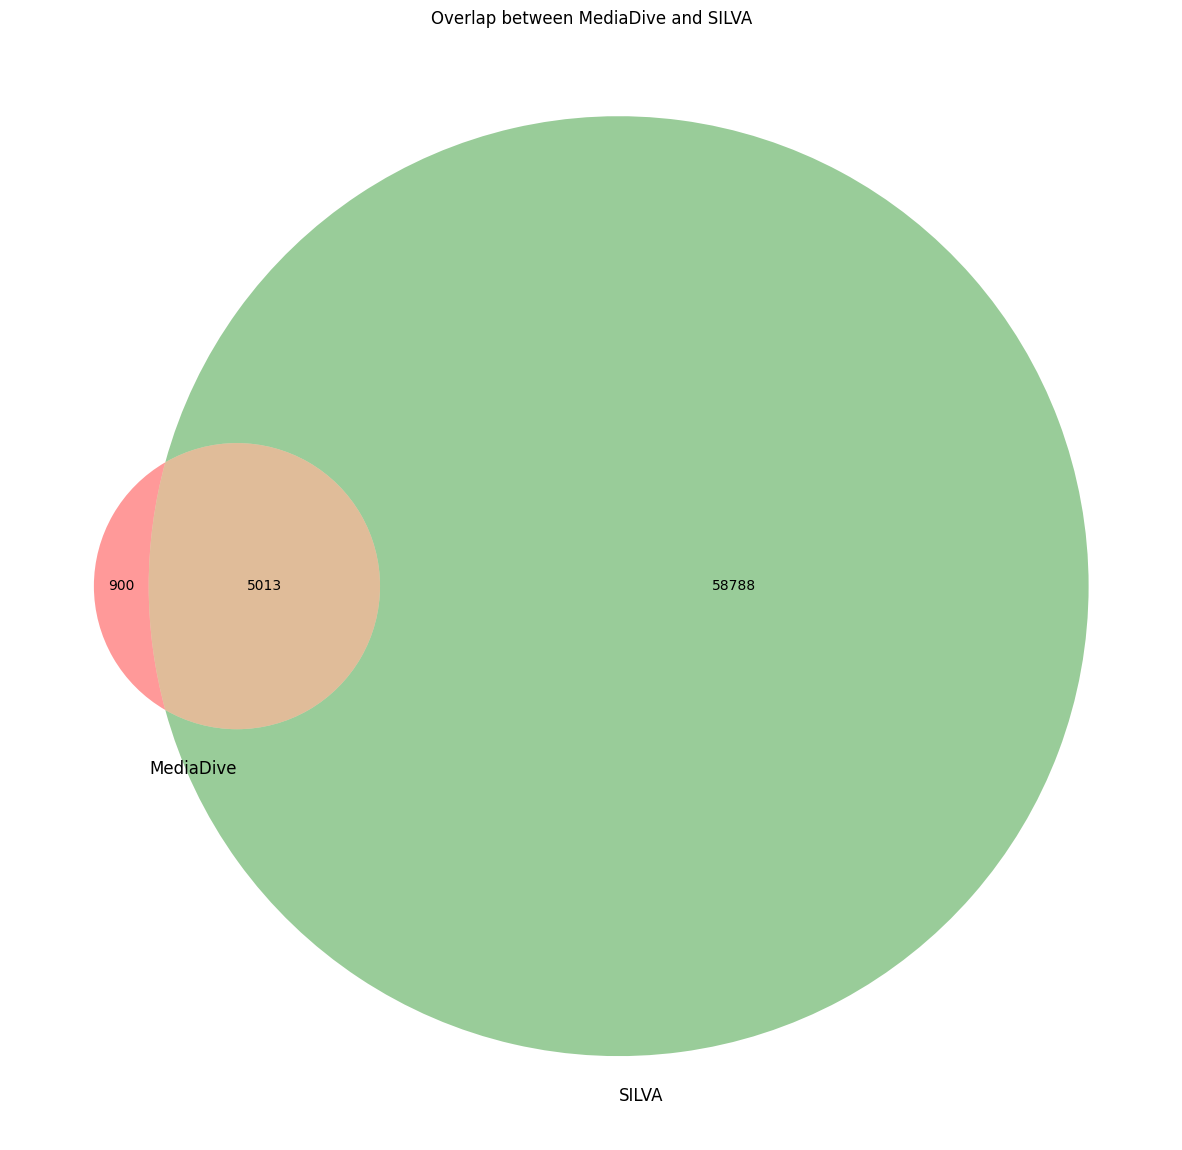

In [14]:
mediadive_ids = mediadive_df["taxon_id"].to_numpy()
silva_ids = silva_taxmap["taxon_id"].to_numpy()

plt.figure(figsize=(15, 15))
venn2(
    [set(mediadive_ids), set(silva_ids)],
    set_labels=["MediaDive", "SILVA"]
)
plt.title("Overlap between MediaDive and SILVA")

Text(0.5, 1.0, 'Overlap between MediaDive and SILVA')

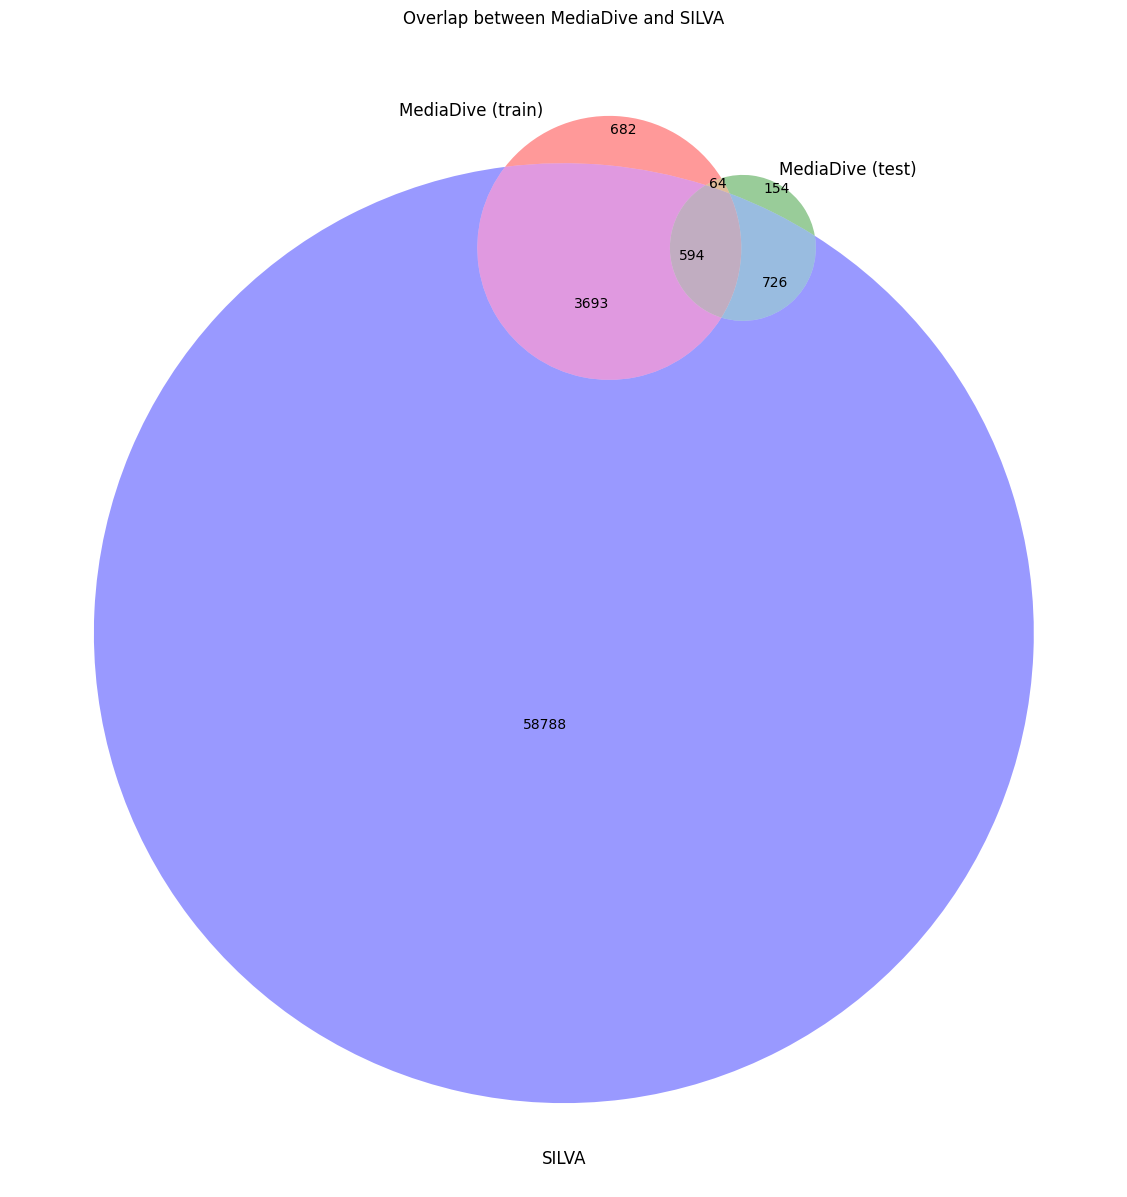

In [10]:
plt.figure(figsize=(15, 15))
venn3(
    [set(train_ids), set(test_ids), set(silva_ids)],
    set_labels=["MediaDive (train)", "MediaDive (test)", "SILVA"]
)
plt.title("Overlap between MediaDive and SILVA")

In [11]:
taxa_counts = merged_df["taxon_id"].value_counts().reset_index()
taxa_counts = taxa_counts[taxa_counts["count"] > 1]
taxa_counts = pd.merge(
    left=taxa_counts,
    right=mediadive_df,
    on="taxon_id",
    how="inner"
)

px.box(
    data_frame=taxa_counts,
    y="count",
    color="Set",
    hover_data=["taxon_id"],
    title="Number of sequences in SILVA for each taxon ID",
    template="plotly_white"
)

## Sequence similarity

In [15]:
aligner = Align.PairwiseAligner(
    mode="global",
    scoring="blastn",
    match_score=2,
    mismatch_score=-1,
    # open_gap_score=-7,
    # extend_gap_score=-2
)
print(aligner)

Pairwise sequence aligner with parameters
  wildcard: None
  match_score: 2.000000
  mismatch_score: -1.000000
  target_internal_open_gap_score: -7.000000
  target_internal_extend_gap_score: -2.000000
  target_left_open_gap_score: -7.000000
  target_left_extend_gap_score: -2.000000
  target_right_open_gap_score: -7.000000
  target_right_extend_gap_score: -2.000000
  query_internal_open_gap_score: -7.000000
  query_internal_extend_gap_score: -2.000000
  query_left_open_gap_score: -7.000000
  query_left_extend_gap_score: -2.000000
  query_right_open_gap_score: -7.000000
  query_right_extend_gap_score: -2.000000
  mode: global



In [ ]:
# Drop duplicates since there is more than one sequence per taxon ID
silva_taxmap_reduced = silva_taxmap.drop_duplicates(
    subset="taxon_id",
    keep="first"
)

results_df = []

for _, query_row in merged_df.iterrows():

    query_df = []
    
    for _, target_row in silva_taxmap_reduced.iterrows():
        query_df.append(
            pd.Series({
                "query_id": query_row["taxon_id"],
                "target_id": target_row["taxon_id"],
                "score": aligner.score(query_row["seq"], target_row["seq"])
            }).to_frame().T
        )

    # Only add maximum score alignment
    query_df = pd.concat(query_df)
    query_df = query_df\
        .sort_values("score", ascending=False)\
        .iloc[0]\
        .to_frame().T

    results_df.append(query_df)
    print(
        f"[{query_df['query_id']}] Found target similar sequence:",
        query_df["target_id"]
    )

results_df = pd.concat(results_df).sort_values("score", ascending=False)

results_df = pd.merge(
    left=results_df,
    right=mediadive_df,
    left_on="query_id",
    right_on="taxon_id",
    how="inner"
)
results_df = results_df.drop("taxon_id", axis=1)

results_df = results_df[[
    "query_id",
    "target_id",
    "score",
    "Set"
]]

results_df

In [ ]:
results_df.to_csv(
    os.path.join(
        DATA_DIR,
        "final_split",
        "baseline_results.csv"
    ),
    index=False
)